In [5]:
import numpy as np
from astropy.io import fits
from numpy.lib.function_base import _calculate_shapes
import pandas as pd
import os
import math

Mount google drive and set the path where our data is stored. We can also use local files but they are slower to upload

In [6]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = "drive/MyDrive/Colab Notebooks/SKAData/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the fits file from the drive and extract the image

In [7]:
fits_img = fits.open(dir_path + "SKAMid_B1_8h_v3.fits")
#print(fits_img.info())
fits_img=fits_img[0].data[0,0,:,:]

Parameter settings:
since when using the entire image the RAM of the system fills easily, we can 

*   since, when using the entire image the RAM of the system fills easily, we can use the image_size variable to work only on a portion of the image
*   cutout_size is the size of the squares in which the image is divided


In [8]:
cutout_size = 218
#image_size = 32700
image_size = 15260
cutouts_per_row = image_size//cutout_size

Divide the image

In [ ]:
cutouts = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  print(i)
  for j in range(0,cutouts_per_row):
    cutouts[i*cutouts_per_row+j] = fits_img[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

Upload the already filtered training set from the drive

In [11]:
FilteredTrainingSet=pd.read_csv(dir_path + "filtered_training_set.csv",)

Generate images from the training set where each dot corresponds to a source

In [12]:
data=np.zeros((image_size,image_size), dtype=np.uint8 )
for i in range(0,len(FilteredTrainingSet)):
	    data[int(FilteredTrainingSet['y'][i]),int(FilteredTrainingSet['x'][i])] = 1

Divide the data generated images

In [ ]:
data_array = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  print(i)
  for j in range(0,cutouts_per_row):
    data_array[i*cutouts_per_row+j] = data[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

In [15]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

Define the model

In [16]:
input_layer = Input(shape=(cutout_size, cutout_size, 1))
x = Conv2D(16, (7, 7), strides=1, activation='relu', padding='same')(input_layer)
x = Dropout(0.25)(x)
x = Conv2D(32, (5, 5), strides=1, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
output_layer = Dense(1,activation='sigmoid')(x)

myCNN = Model(input_layer,output_layer)
#es=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
adadelta = optimizers.Adadelta(learning_rate=1.0, decay=0.0, rho=0.99)
myCNN.compile(optimizer=adadelta, loss='binary_crossentropy')

print(myCNN.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 218, 218, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 16)      800       
_________________________________________________________________
dropout (Dropout)            (None, 218, 218, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 218, 218, 32)      12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 64)      18496     
_________________________________________________________________
dense (Dense)                (None, 218, 218, 1)       65        
Total params: 32,193
Trainable params: 32,193
Non-trainable params: 0
_________________________________________________________

Divide images and data in training and test set
Current proportion used is 80 train/20 test

In [17]:
img_array = cutouts
train_X = img_array[0:int(0.8*len(img_array))]
test_X = img_array[int(0.8*len(img_array)):len(img_array)]
train_Y = data_array[0:int(0.8*len(data_array))]
test_Y = data_array[int(0.8*len(data_array)):len(data_array)]

Training of our model

In [18]:
base_history = myCNN.fit(train_X, train_Y, epochs=10, batch_size=128, shuffle=True, validation_data=(test_X, test_Y), verbose=1)

Epoch 1/10
31/31 [==============================] - 1149s 37s/step - loss: 0.1530 - val_loss: 0.0011
Epoch 2/10
31/31 [==============================] - 1156s 37s/step - loss: 0.0020 - val_loss: 5.2030e-04
Epoch 3/10
31/31 [==============================] - 1162s 38s/step - loss: 0.0017 - val_loss: 3.7614e-04
Epoch 4/10
31/31 [==============================] - 1162s 38s/step - loss: 0.0017 - val_loss: 3.1407e-04
Epoch 5/10
31/31 [==============================] - 1164s 38s/step - loss: 0.0017 - val_loss: 2.7858e-04
Epoch 6/10
31/31 [==============================] - 1167s 38s/step - loss: 0.0017 - val_loss: 2.5837e-04
Epoch 7/10
31/31 [==============================] - 1169s 38s/step - loss: 0.0017 - val_loss: 2.4671e-04
Epoch 8/10
31/31 [==============================] - 1163s 38s/step - loss: 0.0017 - val_loss: 2.4035e-04
Epoch 9/10
31/31 [==============================] - 1147s 37s/step - loss: 0.0017 - val_loss: 2.3346e-04
Epoch 10/10
31/31 [==============================] - 1148s 

In [19]:
print(base_history.history.keys())

dict_keys(['loss', 'val_loss'])


In [20]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [21]:
plot_history(base_history,['accuracy','val_accuracy'])

KeyError: ignored

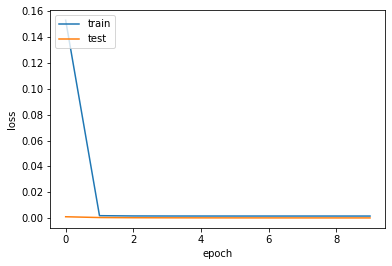

In [22]:
plot_history(base_history,['loss','val_loss'])